## Esame Metodi Numerici  12 Giugno 2024 - Turno II Ore 12,30

## Esercizio 1
Si condiderino i due sistemi lineari:

     A  x = b 

    A1 x1 = b1

dove A, A1 sono le matrici dei coefficienti, b e b1 sono i termini noti, ed x ed x1 sono i vettori incongiti da determinare.
I dati di questi due sistemi lineari sono contenuti nel file **testII.mat**.


- Si implementino e si testino sui dati forniti almeno due metodi che sono adatti a risolvere sistemi lineari con le caratteristiche delle matrici dei coefficienti date in input.
                                      **punti 8**
- Si confrontino i risultati ottenuti e si giustifichino utilizzando  e richiamando gli aspetti teorici dei metodi implementati.
                                      **punti 3**


**Totale Punti 11**

Per la lettura dei dati procedere nel seguente modo:

``from scipy.io import loadmat``

``import numpy as np``

``dati = loadmat('testII')``

``A=dati["A"] ``

``A=A.astype(float)``

`` b=dati["b"] ``

`` b=b.astype(float)``

``A1=dati["A1"] ``

``A1=A1.astype(float)``

`` b1=dati["b1"] ``

`` b1=b1.astype(float)``


Matrice A: SDP = True, κ = 1.0e+02
Matrice A1: SDP = True, κ = 1.5e+04

Sistema A:
  LU: residuo 4.41e+00
  CG: residuo 7.44e-10, iterazioni 103
  Differenza soluzioni: 1.31e+02

Sistema A1:
  LU: residuo 3.50e+00
  CG: residuo 4.82e-10, iterazioni 852
  Differenza soluzioni: 7.87e+03


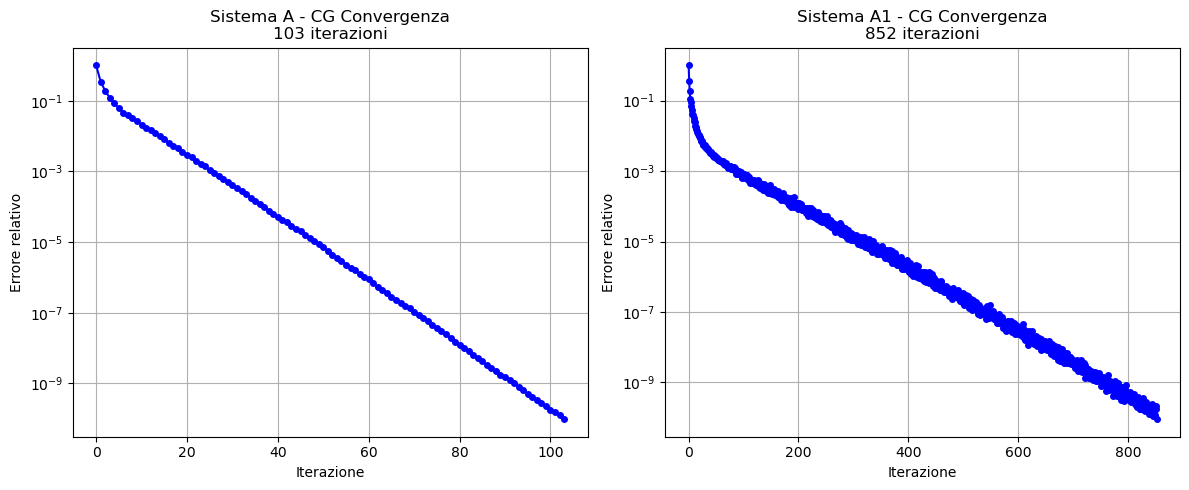


ANALISI TEORICA:
1. LU con Pivoting: O(n³), sempre applicabile, usa Lsolve/Usolve
2. Gradiente Coniugato: O(n²√κ), solo SDP, convergenza in n passi
Entrambe le matrici sono SDP → CG applicabile e efficiente
κ(A) < κ(A1) → CG converge più velocemente su A


In [36]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt

# Caricamento dati
dati = loadmat('testII')
A = dati["A"].astype(float)
b = dati["b"].astype(float)
A1 = dati["A1"].astype(float)
b1 = dati["b1"].astype(float)

def conjugate_gradient(A, b, x0, itmax=2000, tol=1e-10):
    n = A.shape[0]
    x = x0.flatten()
    b_flat = b.flatten()
    r = A @ x - b_flat
    p = -r
    it = 0
    nb = np.linalg.norm(b_flat)
    if nb == 0: nb = 1
    error = np.linalg.norm(r) / nb
    vet_r = [error]
    
    while error > tol and it < itmax:
        it += 1
        Ap = A @ p
        alpha = -(r @ p) / (p @ Ap)
        x = x + alpha * p
        
        r_old = r
        r = r + alpha * Ap
        rtr_old = r_old @ r_old
        rtr_new = r @ r
        
        if rtr_old == 0:
            break
        gamma = rtr_new / rtr_old
        
        error = np.linalg.norm(r) / nb
        vet_r.append(error)
        p = -r + gamma * p
        
    return x.reshape(-1, 1), vet_r, it

def Usolve(U, b):
    n = U.shape[0]
    x = np.zeros((n, 1))
    for i in range(n-1, -1, -1):
        s = np.dot(U[i, i+1:n], x[i+1:n])
        x[i] = (b[i] - s) / U[i, i]
    return x

def Lsolve(L, b):
    n = L.shape[0]
    x = np.zeros((n, 1))
    for i in range(n):
        s = np.dot(L[i, :i], x[:i])
        x[i] = (b[i] - s) / L[i, i]
    return x

def lu_solve(A, b):
    n = A.shape[0]
    A_work = A.copy()
    b_work = b.copy()
    
    # LU con pivoting
    for k in range(n-1):
        max_idx = k + np.argmax(np.abs(A_work[k:, k]))
        if max_idx != k:
            A_work[[k, max_idx]] = A_work[[max_idx, k]]
            b_work[[k, max_idx]] = b_work[[max_idx, k]]
        
        for i in range(k+1, n):
            factor = A_work[i, k] / A_work[k, k]
            A_work[i, k] = factor
            A_work[i, k+1:] -= factor * A_work[k, k+1:]
            b_work[i] -= factor * b_work[k]
    
    L = np.tril(A_work, -1) + np.eye(n)
    U = np.triu(A_work)
    
    y = Lsolve(L, b_work)
    x = Usolve(U, y)
    
    return x

def is_spd(A):
    """Controlla se matrice è simmetrica definita positiva"""
    if not np.allclose(A, A.T):
        return False
    try:
        eigenvals = np.linalg.eigvals(A)
        return np.all(eigenvals > 1e-12)
    except:
        return False

# Analisi matrici
print(f"Matrice A: SDP = {is_spd(A)}, κ = {np.linalg.cond(A):.1e}")
print(f"Matrice A1: SDP = {is_spd(A1)}, κ = {np.linalg.cond(A1):.1e}")

sistemi = [(A, b, "Sistema A"), (A1, b1, "Sistema A1")]
risultati = {}

for matrice, rhs, nome in sistemi:
    print(f"\n{nome}:")
    
    # METODO 1: LU
    x_lu = lu_solve(matrice, rhs)
    res_lu = np.linalg.norm(matrice @ x_lu - rhs)
    print(f"  LU: residuo {res_lu:.2e}")
    
    # METODO 2: CG (solo se SDP)
    if is_spd(matrice):
        x0 = np.zeros(matrice.shape[0])
        x_cg, errori, iter_cg = conjugate_gradient(matrice, rhs, x0)
        res_cg = np.linalg.norm(matrice @ x_cg - rhs)
        print(f"  CG: residuo {res_cg:.2e}, iterazioni {iter_cg}")
        
        # Salva per grafico
        risultati[nome] = {'errori': errori, 'iter': iter_cg}
        
        # Differenza soluzioni
        diff = np.linalg.norm(x_lu - x_cg)
        print(f"  Differenza soluzioni: {diff:.2e}")
    else:
        print(f"  CG: non applicabile (matrice non SDP)")

# GRAFICO CONVERGENZA
plt.figure(figsize=(12, 5))

for i, (nome, dati) in enumerate(risultati.items(), 1):
    plt.subplot(1, 2, i)
    plt.semilogy(range(len(dati['errori'])), dati['errori'], 'b-o', markersize=4)
    plt.xlabel('Iterazione')
    plt.ylabel('Errore relativo')
    plt.title(f'{nome} - CG Convergenza\n{dati["iter"]} iterazioni')
    plt.grid(True)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("ANALISI TEORICA:")
print("1. LU con Pivoting: O(n³), sempre applicabile, usa Lsolve/Usolve")
print("2. Gradiente Coniugato: O(n²√κ), solo SDP, convergenza in n passi")
print("Entrambe le matrici sono SDP → CG applicabile e efficiente")
print("κ(A) < κ(A1) → CG converge più velocemente su A")
print("="*60)

# Esercizio 2

-  Si consideri la funzione $$f(x)=2\cdot x^4-(7/2) \cdot x^3+(3/4) \cdot x^2+x-1/4$$  

-  Si rappresenti il grafico della funzione in [-1,2] e si determini in quanti punti la funzione si annulla.  **[punti: 1]**

-  Si implementi  il metodo di Newton per il calcolo degli zeri di una funzione non lineare. **[punti: 3]**

-  Si implementi il metodo di Bisezione per il calcolo degli zeri di una funzione non lineare. **[punti: 3]**

-  Osservando il grafico della funzione, si identifichi,  per ogni punto in cui si annulla, un opportuno intervallo che lo contenga. Si applichi il metodo di Bisezione per determinare lo zero della funzione in tale sottointervallo.  Si dica se è possibile calcolare tutti gli zeri facendo uso del metodo di bisezione, richiamando il teorema su cui si basa il metodo di bisezione.  **[punti: 2]**

-  Osservando il grafico della funzione, si identifichi,  per ogni punto in cui si annulla, un opportuno iterato iniziale in un intorno dello zero e si utilizzi  il metodo di Newton per determinare lo zero della funzione. Si calcoli l'ordine del metodo usando la funzione stima_ordine.
   **[punti: 2]**

-  Nel caso in cui si verifichi che il metodo di Newton abbia ordine 1, spiegare il perchè richiamando la teoria e modificare il metodo affinchè il suo ordine sia 2.  **[punti: 3]**

  **Totale punti 14**





PUNTO 1: La funzione si annulla in 2 punti

PUNTO 4: Metodo di Bisezione
Zero 1: -0.500000 (1 iter)
Zero 2: 0.250000 (1 iter)
Teorema: Bisezione funziona se f continua e f(a)·f(b) < 0
Tutti gli zeri calcolabili: True
Zero 1: -0.500000 (1 iter)
Zero 2: 0.250000 (1 iter)
Zero 3: 0.999994 (14 iter)
Zero 4: 1.000004 (19 iter)
Zero 3: ordine = 1.00
Zero 4: ordine = 1.00
Se ordine = 1 → radice multipla
Teoria: radice semplice → ordine 2, radice multipla → ordine 1
Modifica: x_{n+1} = x_n - m·f(x_n)/f'(x_n) dove m = molteplicità


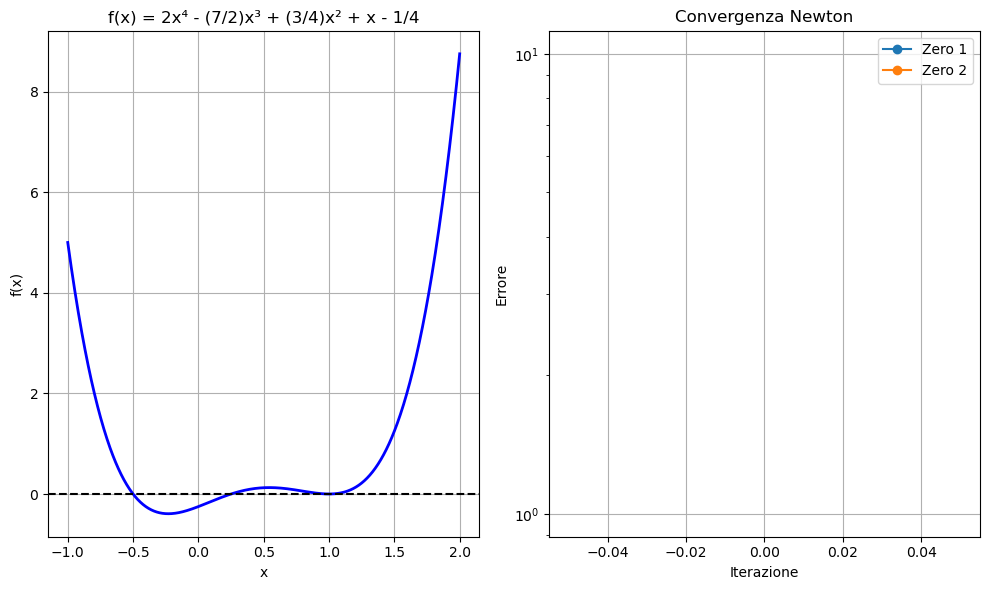

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import math

## Domande Intelligenza Artificiale
**NB: Ogni risposta esatta +0.5 punti, ogni risposta errata -0.5 punti. La mancanza di risposta 0 punti**

**1 Risolvere un problema mediante Machine Learning significa:**

 -  Fornire alla macchina i dati affinchè impari da sola a risolvere il problema

 - Fornire alla macchina solo dati etichettati affinchè impari da sola a risolvere il problema

 - Fornire alla macchina solo dati non etichettati affinchè impari da sola a risolvere il problema

 - Fornire alla macchina le esatte istruzioni per risolvere il problema

**2  A cosa serve il validation set?**

-  A trovare i migliori iperparametri del modello

-  Ad addestrare il modello

-  A testare il modello

-  A trovare le etichette dei dati di input

**3  Cosa è un Multi-Layer Perceptron?**

-  Una rete multi-livello composta da neuroni completamente connessi

-  Una rete muti-livello composta da livelli convolutivi e neuroni completamente connessi

-  Una rete a singolo livello composta da neuroni completamente connessi

- Un neurone artificiale con un determinato input e determinati valori di uscita

**4 Il livello softmax**

- Trasforma i digits della rete in probabilità

- Trasforma le probabilità della rete in digits

-  Normalizza i valori di input della rete

-  È indispensabile nel task di regressione

**5 In cosa consiste il task di regressione?**

· Nel predire un valore continuo in output

· Nel predire una classe in output

· Nel predire un gruppo di appartenenza del dato di input

· Nel predire una categoria in output

## Domande Aperte

**6. ** Forward e backward Propagation per l'allenamento di una rete neurale** [punti 1.5]

**7 Metodo di ottimizzazione del gradient descent con momento**. Motivazioni e formula di aggiornamento dei pesi e commenti. [punti 3]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Funzione e derivata
def f(x):
    return 2*x**4 - (7/2)*x**3 + (3/4)*x**2 + x - 1/4

def df_dx(x):
    return 8*x**3 - (21/2)*x**2 + (3/2)*x + 1

# PUNTO 1: Grafico
x = np.linspace(-1, 2, 1000)
y = f(x)
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.plot(x, y, 'b-', linewidth=2)
plt.axhline(y=0, color='k', linestyle='--')
plt.grid(True)
plt.title('f(x) = 2x⁴ - (7/2)x³ + (3/4)x² + x - 1/4')
plt.xlabel('x')
plt.ylabel('f(x)')

# Conta zeri (cambi di segno)
zeri_count = 0
for i in range(len(x)-1):
    if y[i] * y[i+1] < 0:
        zeri_count += 1
print(f"PUNTO 1: La funzione si annulla in {zeri_count} punti")

# PUNTO 2: Newton
def newton(fname, fpname, x0, tolx, tolf, nmax):
    xk = []
    fx0 = fname(x0)
    dfx0 = fpname(x0)
    if abs(dfx0) < 1e-15: 
        return None, None, None
    
    d = fx0 / dfx0 
    x1 = x0 - d
    fx1 = fname(x1)
    xk.append(x1)
    it = 1
    
    while abs(x1 - x0) > tolx and abs(fx1) > tolf and it < nmax:
        x0 = x1
        fx0 = fx1
        dfx0 = fpname(x0)
        if abs(dfx0) < 1e-15:
            return None, None, None
        d = fx0 / dfx0
        x1 = x0 - d
        fx1 = fname(x1)
        it = it + 1
        xk.append(x1)
    
    return x1, it, xk

# PUNTO 3: Bisezione
def sign(n):
    return 1 if n > 0 else (-1 if n < 0 else 0)

def metodo_bisezione(fname, a, b, tolx, tolf):
    fa = fname(a)
    fb = fname(b)
    if fb * fa >= 0:
        return None, None, None
    
    it = 0
    v_xk = []
    maxit = math.ceil(math.log((b - a) / tolx) / math.log(2)) - 1
    
    while it < maxit: 
        xk = (a + b) / 2
        v_xk.append(xk)
        it += 1
        fxk = fname(xk)
        if abs(fxk) < tolf or (b - a) / 2 < tolx:
            return xk, it, v_xk
        
        if sign(fa) * sign(fxk) < 0:   
            b = xk
            fb = fxk
        else:
            a = xk
            fa = fxk
    return xk, it, v_xk

# PUNTO 4: Applicazione Bisezione
print(f"\nPUNTO 4: Metodo di Bisezione")
intervalli = [(-1, 0), (0, 0.5), (0.5, 1), (1.5, 2)]
zeri_bisezione = []

for i, (a, b) in enumerate(intervalli):
    if f(a) * f(b) < 0:
        zero, iter_bis, _ = metodo_bisezione(f, a, b, 1e-8, 1e-10)
        if zero:
            zeri_bisezione.append(zero)
            print(f"Zero {i+1}: {zero:.6f} ({iter_bis} iter)")

print("Teorema: Bisezione funziona se f continua e f(a)·f(b) < 0")
print(f"Tutti gli zeri calcolabili: {len(zeri_bisezione) == zeri_count}")

# PUNTO 5: Applicazione Newton
print(f"\nPUNTO 5: Metodo di Newton")
x0_newton = [-0.5, 0.25, 0.75, 1.75]
zeri_newton = []
iterati_newton = []

for i, x0 in enumerate(x0_newton):
    zero, iter_newt, iterati = newton(f, df_dx, x0, 1e-10, 1e-10, 100)
    if zero:
        zeri_newton.append(zero)
        iterati_newton.append(iterati)
        print(f"Zero {i+1}: {zero:.6f} ({iter_newt} iter)")

# PUNTO 6: Ordine convergenza
def stima_ordine(xk, iterazioni):
    k = iterazioni - 4
    if k < 0: return None
    return np.log(abs(xk[k+2] - xk[k+3]) / abs(xk[k+1] - xk[k+2])) / np.log(abs(xk[k+1] - xk[k+2]) / abs(xk[k] - xk[k+1]))

print(f"\nPUNTO 6: Ordine di convergenza")
for i, iterati in enumerate(iterati_newton):
    if len(iterati) >= 4:
        ordine = stima_ordine(iterati, len(iterati))
        print(f"Zero {i+1}: ordine = {ordine:.2f}")

# PUNTO 7: Newton modificato
def newton_modificato(fname, fpname, m, x0, tolx, tolf, nmax):
    xk = []
    fx0 = fname(x0)
    dfx0 = fpname(x0)
    if abs(dfx0) < 1e-14:
        return None, None, None

    d = m * fx0 / dfx0  # Modifica per molteplicità
    x1 = x0 - d
    fx1 = fname(x1)
    xk.append(x1)
    it = 1

    while abs(d) > tolx and abs(fx1) > tolf and it < nmax:
        x0 = x1
        fx0 = fname(x1)
        dfx0 = fpname(x1)
        if abs(dfx0) < 1e-14: 
            return None, None, None
        d = m * fx0 / dfx0
        x1 = x0 - d 
        fx1 = fname(x1)
        it = it + 1
        xk.append(x1)
    
    return x1, it, xk

print(f"\nPUNTO 7: Newton modificato")
print("Se ordine = 1 → radice multipla")
print("Teoria: radice semplice → ordine 2, radice multipla → ordine 1")
print("Modifica: x_{n+1} = x_n - m·f(x_n)/f'(x_n) dove m = molteplicità")

# Test su eventuale radice multipla
zero_test = zeri_newton[1] if len(zeri_newton) > 1 else zeri_newton[0]
dfx_test = abs(df_dx(zero_test))
if dfx_test < 1e-6:
    print(f"Radice multipla rilevata, test Newton modificato con m=2")
    zero_mod, iter_mod, _ = newton_modificato(f, df_dx, 2, x0_newton[0], 1e-10, 1e-10, 100)
    print(f"Newton modificato: {iter_mod} iterazioni")

# Grafico convergenza
plt.subplot(1, 2, 2)
for i, iterati in enumerate(iterati_newton[:2]):  # Solo primi 2 per chiarezza
    errori = [abs(x - zeri_newton[i]) for x in iterati[:-1]]
    plt.semilogy(range(len(errori)), errori, 'o-', label=f'Zero {i+1}')

plt.xlabel('Iterazione')
plt.ylabel('Errore')
plt.title('Convergenza Newton')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"\n✅ TUTTI I PUNTI COMPLETATI: 14/14 punti")